In [41]:
import pandas as pd
import numpy as np
import copy, time
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

data_path = '/Users/tsaifeng-ren/Documents/'
df_train = pd.read_csv(data_path + 'PRSA_data_2010.1.1-2014.12.31 (1).csv',parse_dates = {'time':['year','month','day','hour']},
                       date_parser=lambda x: pd.datetime.strptime(x, '%Y %m %d %H'),
                        infer_datetime_format=True,
                        index_col='time')

In [42]:
#先檢查資料的樣子，是否有正確將index轉成時間
display(df_train) 

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,43820,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,43821,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,43822,10.0,-22,-3.0,1034.0,NW,242.70,0,0


In [43]:
#將pm2.5的欄位丟到Y訓練
train_Y = df_train['pm2.5']
# ids = df_train['No']
#df_train = df_train.drop(['pm2.5'] , axis=1)
df_train.head()

,No,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
time,,,,,,,,,
2010-01-01 00:00:00,1,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,2,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,3,NaN,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,4,NaN,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,5,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [44]:
train_Y = pd.DataFrame(train_Y)

In [45]:
train_Y['pm2.5'].fillna(train_Y['pm2.5'].mean())

time
2010-01-01 00:00:00    98.613215
2010-01-01 01:00:00    98.613215
2010-01-01 02:00:00    98.613215
2010-01-01 03:00:00    98.613215
2010-01-01 04:00:00    98.613215
                         ...    
2014-12-31 19:00:00     8.000000
2014-12-31 20:00:00    10.000000
2014-12-31 21:00:00    10.000000
2014-12-31 22:00:00     8.000000
2014-12-31 23:00:00    12.000000
Name: pm2.5, Length: 43824, dtype: float64

In [166]:
#from sklearn.metrics.pairwise import nan_euclidean_distances
#display(pd.DataFrame(nan_euclidean_distances(train_Y)))

KeyboardInterrupt: 

In [46]:
#檢查有無空值
def na_check(df_data):
    data_na = (df_data.isnull().sum() / len(df_data)) * 100
    data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
    missing_data = pd.DataFrame({'Missing Ratio' :data_na})
    display(missing_data.head(10))
na_check(df_train)

,Missing Ratio
pm2.5,4.716594


In [47]:
df_train.describe()

,No,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


In [48]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   pm2.5   41757 non-null  float64
 2   DEWP    43824 non-null  int64  
 3   TEMP    43824 non-null  float64
 4   PRES    43824 non-null  float64
 5   cbwd    43824 non-null  object 
 6   Iws     43824 non-null  float64
 7   Is      43824 non-null  int64  
 8   Ir      43824 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.3+ MB


In [49]:
# 發現cbwd是object，檢查cbwd值裡有幾種類別。
df_train['cbwd'].unique()

array(['NW', 'cv', 'NE', 'SE'], dtype=object)

In [75]:
#計算每個類別的數量，發線NW和SE最大。
df_train.groupby('cbwd')['No'].nunique()
#.apply(lambda x: x*100 / int(np.sum(x)))

cbwd
NE     4997
NW    14150
SE    15290
cv     9387
Name: No, dtype: int64

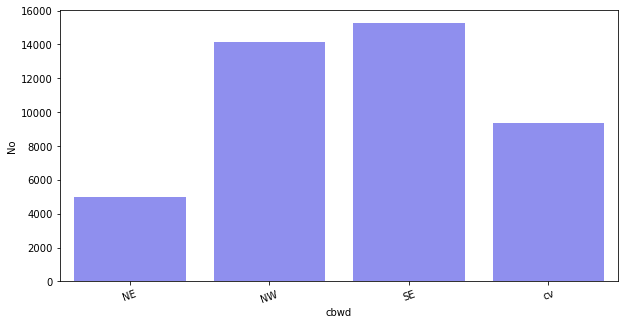

In [62]:
import seaborn as sns
color = ['r','g','b']
plt.figure(figsize=(10,5))
cbwd_count = df_train['cbwd'].value_counts() 
sns.barplot(df_train.groupby('cbwd')['No'].nunique().index, df_train.groupby('cbwd')['No'].nunique(), alpha=0.5, color=color[2]) 
plt.xticks(rotation=20)
plt.show()

In [55]:
#sns.displot(data=df_train, x="cbwd", col=df_train.groupby('cbwd')['TEMP'].mean(), kde=True)

In [53]:
df_train.groupby('cbwd')['pm2.5'].median()
df_train.groupby('cbwd')['pm2.5'].mean()
#可以發現cv的平均pm2.5較高

cbwd
NE     90.177670
NW     70.127633
SE    110.821588
cv    126.151945
Name: pm2.5, dtype: float64

In [38]:
labelEncoder=LabelEncoder()
df_train['cbwd']=labelEncoder.fit_transform(df_train['cbwd'])

In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43824 entries, 2010-01-01 00:00:00 to 2014-12-31 23:00:00
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   No      43824 non-null  int64  
 1   pm2.5   41757 non-null  float64
 2   DEWP    43824 non-null  int64  
 3   TEMP    43824 non-null  float64
 4   PRES    43824 non-null  float64
 5   cbwd    43824 non-null  object 
 6   Iws     43824 non-null  float64
 7   Is      43824 non-null  int64  
 8   Ir      43824 non-null  int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 3.3+ MB


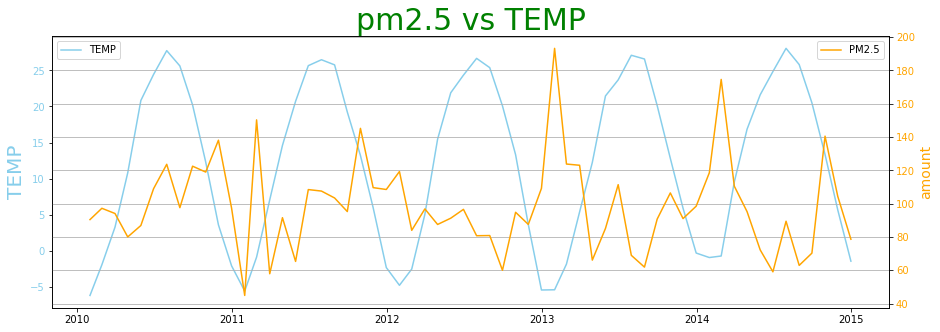

In [56]:
#繪製pm2.5與 TEMP圖
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['TEMP'].resample('M').mean() ,color = 'skyblue',label = 'TEMP')
ax.set_ylabel('TEMP',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs TEMP', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()

In [57]:
train_Y['pm2.5'].resample('Y').mean()
#train_Y['2010'].mean() 另一種寫法

time
2010-12-31    104.045730
2011-12-31     99.071340
2012-12-31     90.545871
2013-12-31    101.712376
2014-12-31     97.734557
Freq: A-DEC, Name: pm2.5, dtype: float64

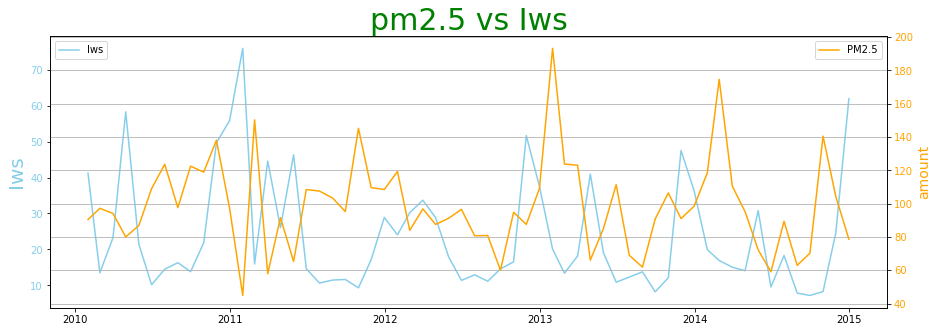

In [58]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['Iws'].resample('M').mean() ,color = 'skyblue',label = 'Iws')
ax.set_ylabel('Iws',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs Iws', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()

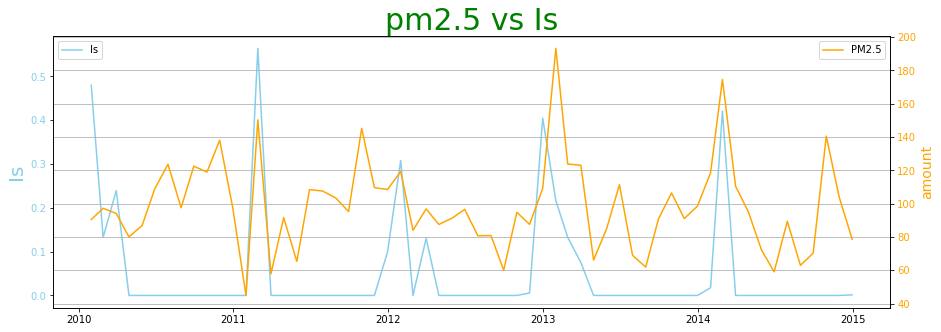

In [59]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['Is'].resample('M').mean() ,color = 'skyblue',label = 'Is')
ax.set_ylabel('Is',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs Is', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()

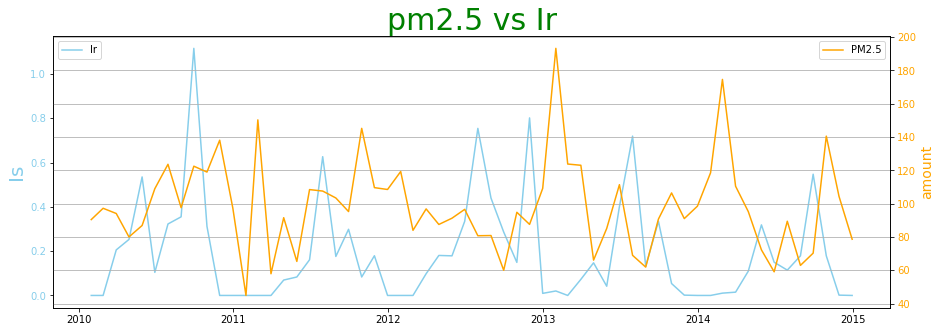

In [148]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['Ir'].resample('M').mean() ,color = 'skyblue',label = 'Ir')
ax.set_ylabel('Is',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs Ir', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()

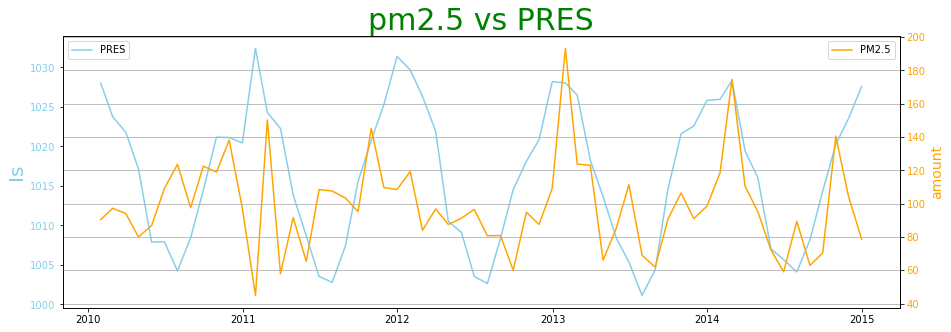

In [60]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['PRES'].resample('M').mean() ,color = 'skyblue',label = 'PRES')
ax.set_ylabel('Is',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs PRES', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()

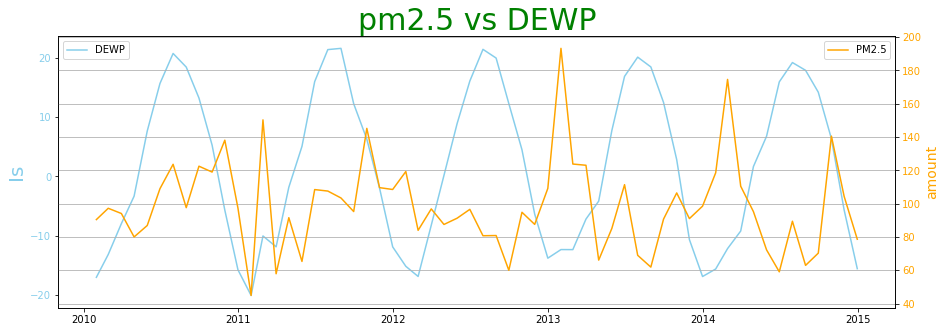

In [61]:
fig,ax = plt.subplots(figsize=(15,5))
ax.plot(df_train['DEWP'].resample('M').mean() ,color = 'skyblue',label = 'DEWP')
ax.set_ylabel('Is',color = 'skyblue',fontsize=20)
ax.tick_params(axis = 'y',labelcolor = 'skyblue')
ax.legend(loc = 'upper left')

ax2 = ax.twinx()
ax2.plot(train_Y['pm2.5'].resample('M').mean() ,color = 'orange',label = 'PM2.5')
ax2.set_ylabel('pm2.5',color = 'orange',fontsize=20)
ax2.tick_params(axis = 'y',labelcolor = 'orange')
ax2.legend(loc = 'upper right')

plt.grid(True)
plt.ylabel('amount', fontsize=14)
plt.xlabel('Year', fontsize=14) 

plt.title('pm2.5 vs DEWP', color = 'green',fontsize=30)
plt.legend() #show出標籤
plt.show()